In [1]:
#suppressing output of the cell
%%capture  
!pip3 install hub==1.0.8
!pip3 install rasterio

In [2]:
#!hub register 
!hub login

Please log in using Activeloop credentials. You can register at https://app.activeloop.ai 
Username: rasha
Password: 
Login Successful.


In [1]:
import hub
from hub import Dataset, features
import numpy as np
from hub.collections import dataset, tensor
from hub.log import logger
import imageio
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from hub.schema import Image
from hub.schema import Tensor
import PIL
from PIL import Image
from matplotlib import image
import rasterio as rio
from matplotlib import pyplot
from rasterio import plot 
import os
import cv2
from osgeo import gdal, osr

In [2]:
%%capture
!unzip "/content/drive/MyDrive/landcovernet_final_tif_NDVI.zip"

In [4]:
# Explore the inputs and targets 
target = image.imread('/content/landcovernet_yes_baby/targets/34JHS_12_2018_LC_10m.png')
root = '/content/landcovernet_yes_baby/inputs/34JHS_12_20180103'

(256, 256)
<class 'numpy.ndarray'>


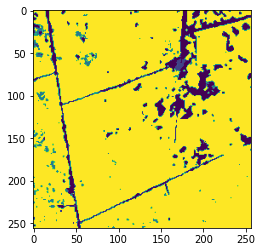

In [5]:
def get_rgb(root) :
  red = rio.open(os.path.join(root, root[-17:]+'_B04_10m.tif')).read(1) 
  green = rio.open(os.path.join(root, root[-17:]+'_B03_10m.tif')).read(1) 
  blue = rio.open(os.path.join(root, root[-17:]+'_B02_10m.tif')).read(1) 

  rgb = np.dstack((red, green, blue))
  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype('uint8')
  return rgb

def get_cust_img(root):
  red = rio.open(os.path.join(root, root[-17:]+'_B04_10m.tif')).read(1) 
  green = rio.open(os.path.join(root, root[-17:]+'_B03_10m.tif')).read(1) 
  blue = rio.open(os.path.join(root, root[-17:]+'_B02_10m.tif')).read(1) 
  ndvi = rio.open(os.path.join(root, root[-17:]+'_NDVI_10m.tif')).read(1)

  custom_img = np.dstack((red, green, blue, ndvi))
  return custom_img
target_root = '/content/landcovernet_yes_baby/targets'
def get_img_mask(target_root, img_root):
  mask =  cv2.imread(os.path.join(target_root, img_root[-17:-4] + "_LC_10m.png"), 0).astype('uint8')
  #mask = np.expand_dims(mask, axis=2)
  #print(os.path.join(target_root, img_root[-17:-4] + "_LC_10m.png"))
  return mask

input = get_rgb(root)
custom_img = get_cust_img(root)
mask = get_img_mask(target_root, root)
print(mask.shape)
pyplot.imshow(mask)
input.shape
print(type(mask))

In [6]:
# Convert mask to one hot encoding
CLASSES = ['otherland', 'cropland', 'pastureland', 'bare soil', 'openwater', 'forestland']
def process_masks(mask, classes = CLASSES):
  CLASSES = ['otherland', 'cropland', 'pastureland', 'bare soil', 'openwater', 'forestland']
  class_value = [CLASSES.index(cls.lower()) for cls in classes]
  masks = [(mask == v) for v in class_value]
  mask = np.stack(masks, axis=-1).astype('uint8')
  return mask

p_mask = process_masks(mask)
print(p_mask.shape)

(256, 256, 6)


In [7]:
# Get the length of the data, shapes, and the datatypes
## Sort the dictionary 
### Get all keys Dictionary1.keys() 
#### Get all values list(d.values())

# Check the shape and dtype
print(mask.shape)
print(mask.dtype)
print(input.shape)

print(input.dtype)

(256, 256)
uint8
(256, 256, 3)
uint8


In [8]:
# First stack all the bands togather
  
inputs_dir = '/content/landcovernet_yes_baby/inputs'
targets_dir = '/content/landcovernet_yes_baby/targets'
def process_tiffs(inputs_dir, target_dir):
  data = []
  sub_dir_list = []
  images_target = {}
  stacked_imgs = []
  list_bands = []
  for sub_dir in os.listdir(inputs_dir):
    # Store the images dir and their target
    sub_dir_list.append(os.path.join(inputs_dir, sub_dir))
  print(sub_dir_list)

  for image_dir in sub_dir_list:
    # Get the rgb version
    rgb = get_rgb(image_dir)
    custom_img = get_cust_img(image_dir)
    mask = get_img_mask(targets_dir, image_dir)
    mask = process_masks(mask) # get the six classes
    # Dictionary of image and its target in numpy format
    images_target = {}
    images_target = {
        'input' : custom_img,
        'input_rgb' : rgb,
        'mask' : mask,
    }
 
    stacked_imgs.append(images_target) # list of dict
 
  return stacked_imgs
  #return images
images_target = process_tiffs(inputs_dir, targets_dir)

['/content/landcovernet_yes_baby/inputs/35LNF_08_20181005', '/content/landcovernet_yes_baby/inputs/33LUD_12_20180103', '/content/landcovernet_yes_baby/inputs/37NFD_20_20180101', '/content/landcovernet_yes_baby/inputs/36MWU_11_20180206', '/content/landcovernet_yes_baby/inputs/35NLA_19_20180708', '/content/landcovernet_yes_baby/inputs/35NRD_22_20180707', '/content/landcovernet_yes_baby/inputs/35NRD_15_20180103', '/content/landcovernet_yes_baby/inputs/33KXV_00_20180115', '/content/landcovernet_yes_baby/inputs/28QDE_18_20180702', '/content/landcovernet_yes_baby/inputs/36MWU_19_20181004', '/content/landcovernet_yes_baby/inputs/28QDE_19_20180702', '/content/landcovernet_yes_baby/inputs/35JQG_04_20180104', '/content/landcovernet_yes_baby/inputs/32PQQ_22_20181009', '/content/landcovernet_yes_baby/inputs/32PRQ_21_20180706', '/content/landcovernet_yes_baby/inputs/34MDU_23_20180701', '/content/landcovernet_yes_baby/inputs/37PCM_04_20181004', '/content/landcovernet_yes_baby/inputs/35LMC_14_2018070

In [9]:
inputs = []
masks = []
rgb_inputs = []
for pairs in images_target:
  inputs.append(pairs['input'])
  masks.append(pairs['mask'])
  rgb_inputs.append(pairs['input_rgb'])


In [ ]:
len(masks)

In [ ]:
rgb_inputs[2000].shape

In [ ]:
for i in range(masks[1].shape[2]):
    mask = masks[1][:, :, i]
    plt.imshow(mask)
    plt.show()
plt.imshow(inputs[1][:, :, 1])
print(masks[1].max())

In [10]:

print(masks[1].dtype)
print(masks[1].shape)
print(rgb_inputs[1].dtype)
print(rgb_inputs[1].shape)
print(inputs[1].dtype)
print(inputs[1].shape)

uint8
(256, 256, 6)
uint8
(256, 256, 3)
float64
(256, 256, 4)


In [12]:
from hub.schema import Image
 
from hub.schema import Tensor
from hub.schema import Mask
from hub.schema import Segmentation

In [14]:
tag = "rasha/landCoverNet_Omdena_Sample"
ds = {}
ds = Dataset(
    tag,
    shape=(2512,),
   mode = "w",  
  schema = {
        "inputs": Tensor((256, 256, 4), dtype="float32"),

        "rgb_inputs": Image(shape=(256, 256, 3),
                         dtype="uint8"),
        "masks": Segmentation(shape=(256, 256, 6), dtype="uint8")
            
    },
)

In [15]:
for i in range(len(masks)):
  ds["masks"][i] = masks[i]
  ds["inputs"][i] = inputs[i]
  ds["rgb_inputs"][i] = rgb_inputs[i]



In [16]:
ds.commit()

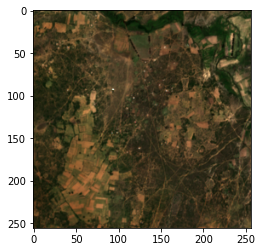

In [22]:
ds = Dataset('rasha/landCoverNet_Omdena_Sample')

# Use .numpy() to get the numpy array of the element
# Bands start from 0 here 
input = (ds["rgb_inputs"][1].numpy()).astype('uint8')
mask = (ds["masks"][1].numpy()).astype('uint8')
pyplot.imshow(input)


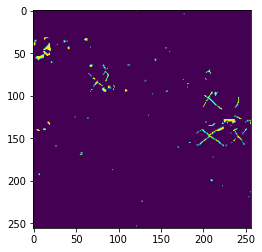

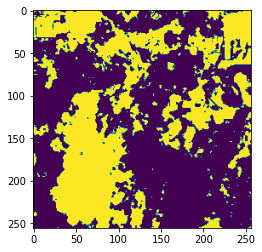

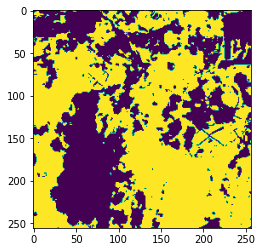

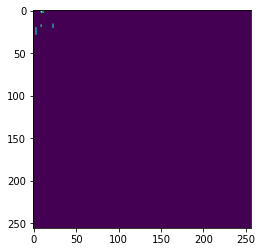

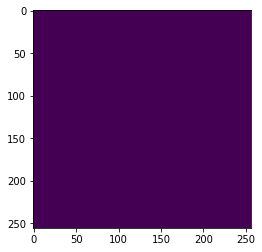

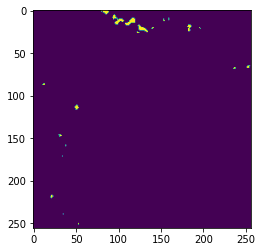

In [23]:
for i in range(mask.shape[2]):
    m = mask[:, :, i]
    plt.imshow(m)
    plt.show()